# Abreu-Sannikov Algorithm for Repeated Two-player Games

In [1]:
using GameTheory
using Polyhedra
using Plots

In [2]:
plib = default_library(2, Float64)

DefaultLibrary{Float64}(nothing)

In [3]:
payoff_points(g::NormalFormGame{2,T}) where {T} = stack(payoff_profile_array(g), dims=1)

payoff_points (generic function with 1 method)

## Replicate the simple example in the paper (p. 322)

The payoff bimatrix is

$$
\begin{bmatrix}
16,9 & 3,13 & 0,3 \\
21,1 & 10,4 & -1,0 \\
9,0 & 5,-4 & -5,-15 \\
\end{bmatrix}
$$

In [4]:
payoff_matrix1 = [16. 3. 0.
                  21. 10. -1.
                  9. 5. -5.]
payoff_matrix2 = [9. 1. 0.
                  13. 4. -4.
                  3. 0. -15.]

g = NormalFormGame(Player(payoff_matrix1), Player(payoff_matrix2))
rpd = RepeatedGame(g, 0.3)

RepeatedGame{2, Float64, Float64}(3×3 NormalFormGame{2, Float64}, 0.3)

In [5]:
v = AS(rpd, u=[0, 0], verbose=true);

converged in 21 iterations


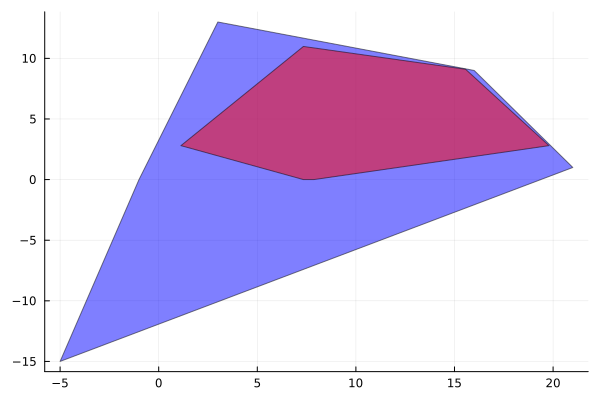

In [6]:
V = vrep(v)
v_init = payoff_points(g)
p_init = polyhedron(vrep(v_init), plib)
plot(p_init, alpha=0.5, color="blue")
plot!(polyhedron(V, plib), alpha=0.5, color="red")

In [7]:
# default library
@time v = AS(rpd, u=[0, 0]);
@time v = AS(rpd, u=[0, 0]);

  0.009174 seconds (117.53 k allocations: 4.975 MiB, 30.50% compilation time)
  0.006201 seconds (115.25 k allocations: 4.847 MiB)


## Replicate the Cournot duopoly game in the paper (p. 326)

In [8]:
# generate Cournot game
# borrow code from quantecon notebook written by Daisuke Oyama
function cournot(a::Real, c::Real, ::Val{N}, q_grid::AbstractVector{T}) where {N,T<:Real}
    nums_actions = ntuple(x->length(q_grid), Val(N))
    S = promote_type(typeof(a), typeof(c), T)
    payoff_array= Array{S}(undef, nums_actions)
    for I in CartesianIndices(nums_actions)
        Q = zero(S)
        for i in 1:N
            Q += q_grid[I[i]]
        end
        payoff_array[I] = (a - c - Q) * q_grid[I[1]]
    end
    players = ntuple(x->Player(payoff_array), Val(N))
    return NormalFormGame(players)
end

cournot (generic function with 1 method)

In [9]:
a, c = 6, 0.6
N = 2
q_grid = collect(LinRange(0, 6, 15))  # [0, 5, 10, ..., 60]
g_Cou = cournot(a, c, Val(N), q_grid)
rpd_Cou = RepeatedGame(g_Cou, 0.8)

RepeatedGame{2, Float64, Float64}(15×15 NormalFormGame{2, Float64}, 0.8)

In [10]:
@time v = AS(rpd_Cou, tol=1e-4, u=[0, 0], verbose=true);
@time v = AS(rpd_Cou, tol=1e-4, u=[0, 0], verbose=true);

converged in 21 iterations
  0.269292 seconds (5.70 M allocations: 249.375 MiB, 12.30% gc time, 1.10% compilation time)
converged in 21 iterations
  0.257911 seconds (5.70 M allocations: 249.299 MiB, 10.65% gc time)


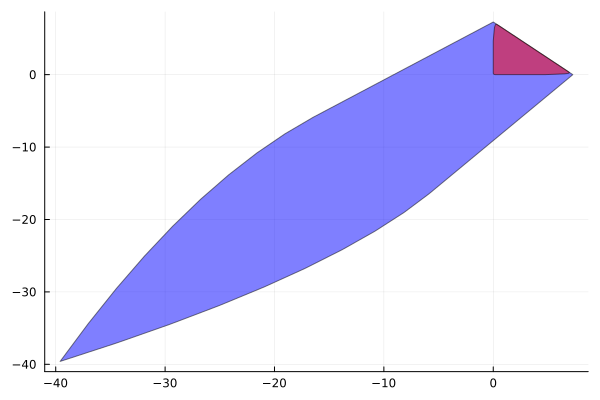

In [11]:
v_init = payoff_points(g_Cou)
p_init = polyhedron(vrep(v_init), plib)
plot(p_init, alpha=0.5, color="blue")
plot!(polyhedron(vrep(v), plib), alpha=0.5, color="red")

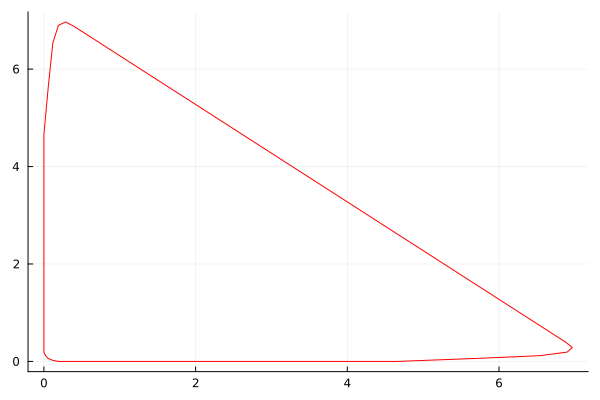

In [12]:
plot(polyhedron(vrep(v), plib), fillcolor=nothing, linecolor="red")

## Compare JYC and AS

We use the same Prisoner Delimma example in the [Repeated Game notebook](https://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/recursive_repeated_games.ipynb#One-Shot-Prisoner's-Dilemma), and compare the speed of JYC and AS.

In [13]:
pd_payoff = [9. 1.
             10. 3.]
pd = NormalFormGame(pd_payoff)

rpd1 = RepeatedGame(pd, 0.9)
rpd2 = RepeatedGame(pd, 0.2475)

RepeatedGame{2, Float64, Float64}(2×2 NormalFormGame{2, Float64}, 0.2475)

First we show the result of JYC algorithm.

In [14]:
@time v = outerapproximation(rpd1; nH=128, maxiter=750, tol=1e-8);
@time v = outerapproximation(rpd1; nH=128, maxiter=750, tol=1e-8);
@time v = outerapproximation(rpd2; nH=128, maxiter=750, tol=1e-8);
@time v = outerapproximation(rpd2; nH=128, maxiter=750, tol=1e-8);

 71.482910 seconds (177.86 M allocations: 9.461 GiB, 1.75% gc time, 6.13% compilation time: 5% of which was recompilation)
 66.816096 seconds (169.48 M allocations: 9.040 GiB, 1.76% gc time, 0.02% compilation time)
  9.216831 seconds (24.78 M allocations: 1.322 GiB, 1.93% gc time)
  8.972638 seconds (24.78 M allocations: 1.322 GiB, 1.80% gc time)


Following is the result of AS algorithm.

In [15]:
@time v1 = AS(rpd1, maxiter=500, verbose=true)
@time v2 = AS(rpd2, maxiter=500, verbose=true)

converged in 111 iterations
  0.298646 seconds (610.88 k allocations: 28.017 MiB, 2.73% gc time, 93.87% compilation time)
converged in 26 iterations
  0.004213 seconds (73.94 k allocations: 3.122 MiB)


6×2 Matrix{Float64}:
 3.0      3.0
 3.0      9.52311
 8.2675   9.06386
 9.0      9.0
 9.06386  8.2675
 9.52311  3.0

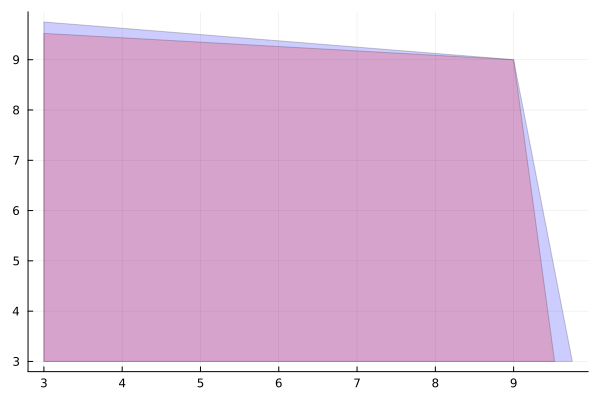

In [16]:
plot(polyhedron(vrep(v1), plib), alpha=0.2, color="blue")
plot!(polyhedron(vrep(v2), plib), alpha=0.2, color="red")